In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Scripts/.' .

In [0]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/train_images320x480.zip'
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/test_images320x480.zip'

### Dependencies

In [4]:
from utillity_script_cloud_segmentation import *

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
#@title
from keras.optimizers import Optimizer

class AdamAccumulated(Optimizer):
    """Adam optimizer with gradient accumulation.
    Default parameters follow those provided in the original paper.
    # Arguments
        accumulation_steps: int > 0. Update gradient in every accumulation steps.
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and Beyond".
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
    """

    def __init__(self, accumulation_steps, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False, **kwargs):
        super(AdamAccumulated, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.accumulation_steps = K.variable(accumulation_steps, dtype='int64', name='accumulation_steps')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        update_cond = K.equal((self.iterations + 1) % self.accumulation_steps, 0)
        sub_step = self.iterations % self.accumulation_steps + 1
        t = K.cast(self.iterations // self.accumulation_steps, K.floatx()) + 1

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))
        lr_t = K.switch(update_cond, lr_t, 0.0)

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]
        self.weights = [self.iterations] + ms + vs + vhats

        acc_grads = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        for grad, acc_grad in zip(grads, acc_grads):
            ave_grad = grad / K.cast(self.accumulation_steps, K.floatx())
            self.updates.append(K.update(
                acc_grad,
                K.switch(
                    K.equal(sub_step, 1),
                    ave_grad,
                    acc_grad + (ave_grad - acc_grad) / K.cast(sub_step, K.floatx())
                ),
            ))
        grads = [K.switch(update_cond, grad, K.zeros_like(grad)) for grad in acc_grads]

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = K.switch(update_cond, (self.beta_1 * m) + (1. - self.beta_1) * g, m)
            v_t = K.switch(update_cond, (self.beta_2 * v) + (1. - self.beta_2) * K.square(g), v)
            if self.amsgrad:
                vhat_t = K.switch(update_cond, K.maximum(vhat, v_t), vhat)
                p_t = p - lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'accumulation_steps': int(K.get_value(self.accumulation_steps)),
                  'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad}
        base_config = super(AdamAccumulated, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [6]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [0]:
base_path = '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/'
data_path = base_path + 'Data/'
classification_model_base_path = base_path + 'Models/files/classification/'
classification_model_path = classification_model_base_path + '19-EfficientNetB0_224x224_Cyclical_triangular.h5'
segmentation_model_base_path = base_path + 'Models/files/segmentation/'
segmentation_model1_path = segmentation_model_base_path + '53-fpn_efficientnetb0_320x480.h5'
segmentation_model2_path = segmentation_model_base_path + '57-unet[fold-2]_efficientnetb3_320x480.h5'
segmentation_model3_path = segmentation_model_base_path + '66-unet_efficientnetb3_320x480.h5'
segmentation_model4_path = segmentation_model_base_path + '71-unet_efficientnetb0_320x480.h5'
submission_base_path = data_path + 'submissions/inference/'
train_path = data_path + 'train.csv'
hold_out_path = data_path + 'hold-out.csv'
test_path = data_path + 'sample_submission.csv'
train_images_path = 'train_images/'
test_images_path = 'test_images/'

### Load data

In [8]:
train = pd.read_csv(train_path)
hold_out_set = pd.read_csv(hold_out_path)
submission = pd.read_csv(test_path)

X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))
print('Test samples:', len(submission))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])

display(submission.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105
Test samples: 14792


,Image_Label,EncodedPixels,image
0,002f507.jpg_Fish,1 1,002f507.jpg
1,002f507.jpg_Flower,1 1,002f507.jpg
2,002f507.jpg_Gravel,1 1,002f507.jpg
3,002f507.jpg_Sugar,1 1,002f507.jpg
4,0035ae9.jpg_Fish,1 1,0035ae9.jpg


# Model parameters

In [0]:
BACKBONE = 'efficientnetb3'
CLASS_HEIGHT = 224
CLASS_WIDTH = 224
SEG_HEIGHT = 320
SEG_WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
TTA_STEPS = 8
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']
best_tresholds_class = [0.64, 0.52, 0.61, 0.59] # beta 0.5

model_name = '60-[seg]53-57-66-71_byClass[class]19-EfficientNetB0'
submission_post_tta_path = submission_base_path + '%s_submission_post_tta.csv' % (model_name)
submission_post_tta_class_path = submission_base_path + '%s_submission_post_class_tta.csv' % (model_name)

In [0]:
preprocessing = sm.get_preprocessing(BACKBONE)

# Model

In [0]:
classification_model = load_model(classification_model_path)
segmentation_model1 = load_model(segmentation_model1_path, custom_objects={'RAdam':RAdam, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})
segmentation_model2 = load_model(segmentation_model2_path, custom_objects={'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})
segmentation_model3 = load_model(segmentation_model3_path, custom_objects={'AdamAccumulated':AdamAccumulated, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})
segmentation_model4 = load_model(segmentation_model4_path, custom_objects={'AdamAccumulated':AdamAccumulated, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

In [96]:
model_weights = [[0.627005, 0.772582,	0.629430, 0.595577],
                 [0.634707, 0.761358, 0.622740, 0.612319],
                 [0.624065, 0.761434, 0.634065, 0.616769],
                 [0.629369, 0.769979, 0.620431, 0.617821]]

model1_weights = [0.627005, 0.772582,	0.629430, 0.595577]
model2_weights = [0.634707, 0.761358, 0.622740, 0.612319]
model3_weights = [0.624065, 0.761434, 0.634065, 0.616769]
model4_weights = [0.629369, 0.769979, 0.620431, 0.617821]

model1_weights /= np.sum(model_weights, axis=0)
model2_weights /= np.sum(model_weights, axis=0)
model3_weights /= np.sum(model_weights, axis=0)
model4_weights /= np.sum(model_weights, axis=0)

print(model1_weights)
print(model2_weights)
print(model3_weights)
print(model4_weights)
print(model1_weights + model2_weights + model3_weights + model4_weights)

[0.24929169 0.25203688 0.25110246 0.2438405 ]
[0.25235394 0.24837531 0.24843358 0.25069499]
[0.24812277 0.2484001  0.25295153 0.2525169 ]
[0.2502316  0.25118771 0.24751243 0.25294761]
[1. 1. 1. 1.]


## Segmentation threshold and mask size tunning

In [0]:
# mask_grid = [0, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500]
# threshold_grid = np.arange(.3, 1, .05)
# best_tresholds_seg, best_masks_seg = segmentation_tunning(segmentation_model, train, X_val, train_images_path, (SEG_HEIGHT, SEG_WIDTH), label_columns, mask_grid, threshold_grid, N_CLASSES, preprocessing, seed, batch_size=300)
best_tresholds_seg = [0.45, 0.45, 0.5, 0.5]
best_masks_seg = [15000, 15000, 20000, 12500]

## Model evaluation

In [0]:
#@title
def get_metrics2(model, target_df, df, df_images_dest_path, target_size, label_columns, tresholds, min_mask_sizes, N_CLASSES=4, seed=0, preprocessing=None, 
                adjust_fn=None, adjust_param=None, set_name='Complete set', column_names=['Class', 'Dice', 'Dice Post'], batch_size=500):
    metrics = []

    for class_name in label_columns:
        metrics.append([class_name, 0, 0])

    metrics_df = pd.DataFrame(metrics, columns=column_names)
    
    for i in range(0, df.shape[0], batch_size):
        batch_idx = list(range(i, min(df.shape[0], i + batch_size)))
        batch_set = df[batch_idx[0]: batch_idx[-1]+1]
        ratio = len(batch_set) / len(df)

        generator = DataGenerator(
                      directory=df_images_dest_path,
                      dataframe=batch_set,
                      target_df=target_df,
                      batch_size=len(batch_set), 
                      target_size=target_size,
                      n_channels=model.input_shape[3],
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      adjust_fn=adjust_fn,
                      adjust_param=adjust_param,
                      seed=seed,
                      mode='fit',
                      shuffle=False)

        x, y = generator.__getitem__(0)
        preds = segmentation_model1.predict(x) * model1_weights
        preds += segmentation_model2.predict(x) * model2_weights
        preds += segmentation_model3.predict(x) * model3_weights
        preds += segmentation_model4.predict(x) * model4_weights
        
        for class_index in range(N_CLASSES):
            class_score = []
            class_score_post = []
            mask_class = y[..., class_index]
            pred_class = preds[..., class_index]
            for index in range(len(batch_idx)):
                sample_mask = mask_class[index, ]
                sample_pred = pred_class[index, ]
                sample_pred_post = post_process(sample_pred, threshold=tresholds[class_index], min_size=min_mask_sizes[class_index])
                sample_pred = post_process(sample_pred, threshold=.5, min_size=0)
                if (sample_mask.sum() == 0) & (sample_pred.sum() == 0):
                    dice_score = 1.
                else:
                    dice_score = dice_coefficient(sample_pred, sample_mask)
                if (sample_mask.sum() == 0) & (sample_pred_post.sum() == 0):
                    dice_score_post = 1.
                else:
                    dice_score_post = dice_coefficient(sample_pred_post, sample_mask)
                class_score.append(dice_score)
                class_score_post.append(dice_score_post)
            metrics_df.loc[metrics_df[column_names[0]] == label_columns[class_index], column_names[1]] += np.mean(class_score) * ratio
            metrics_df.loc[metrics_df[column_names[0]] == label_columns[class_index], column_names[2]] += np.mean(class_score_post) * ratio

    metrics_df = metrics_df.append({column_names[0]:set_name, column_names[1]:np.mean(metrics_df[column_names[1]].values), column_names[2]:np.mean(metrics_df[column_names[2]].values)}, ignore_index=True).set_index(column_names[0])
    
    return metrics_df

In [99]:
train_metrics = get_metrics2(segmentation_model1, train, X_train, train_images_path, (SEG_HEIGHT, SEG_WIDTH), label_columns, best_tresholds_seg, best_masks_seg, seed=seed, preprocessing=preprocessing, set_name='Train', batch_size=300)
display(train_metrics)

validation_metrics = get_metrics2(segmentation_model1, train, X_val, train_images_path, (SEG_HEIGHT, SEG_WIDTH), label_columns, best_tresholds_seg, best_masks_seg, seed=seed, preprocessing=preprocessing, set_name='Validation', batch_size=300)
display(validation_metrics)

,Dice,Dice Post
Class,,
Fish,0.626684,0.679396
Flower,0.769386,0.799595
Gravel,0.601236,0.648718
Sugar,0.599586,0.630890
Train,0.649223,0.689650


,Dice,Dice Post
Class,,
Fish,0.612672,0.667094
Flower,0.765305,0.797238
Gravel,0.593968,0.652819
Sugar,0.581503,0.625298
Validation,0.638362,0.685612


# Inspecting some of the validation set predictions
## Without post-process

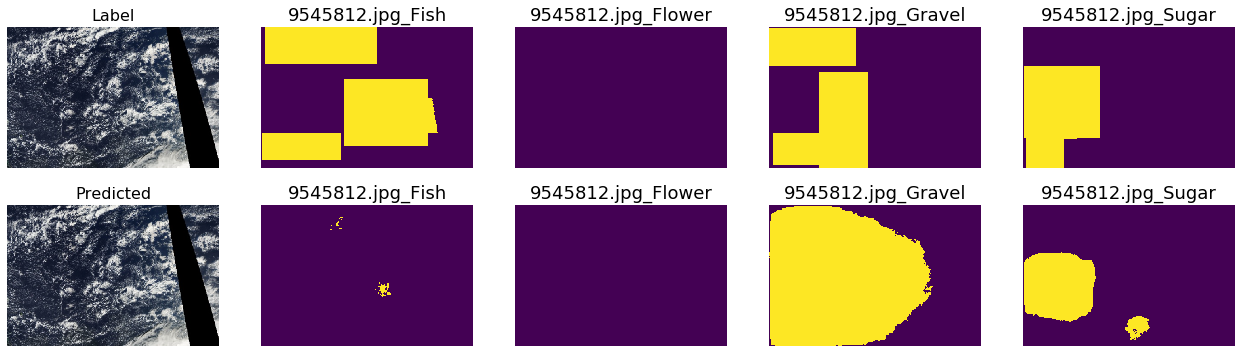

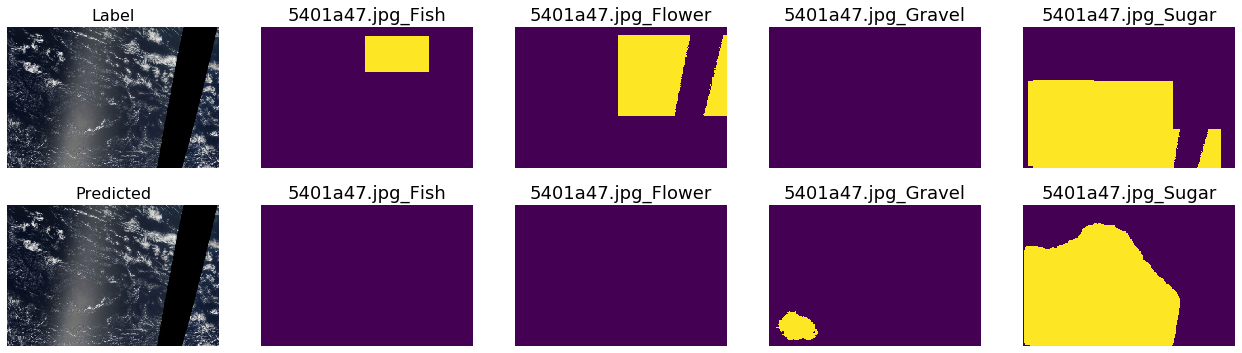

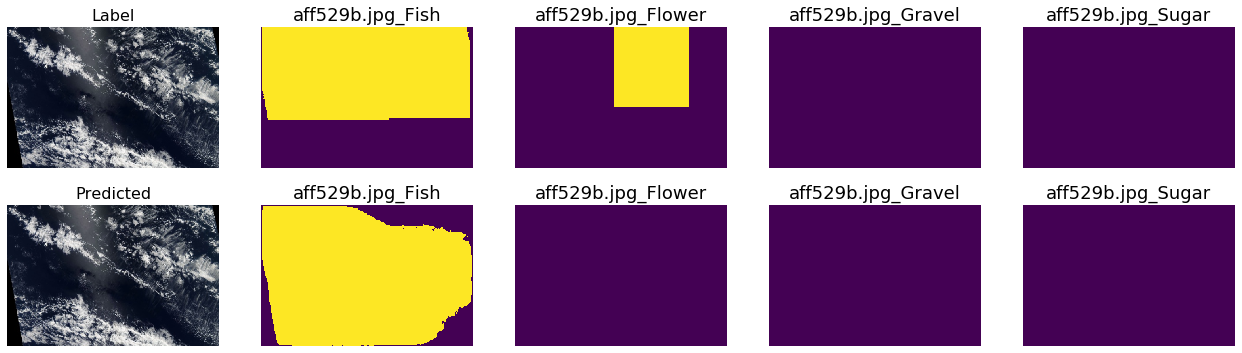

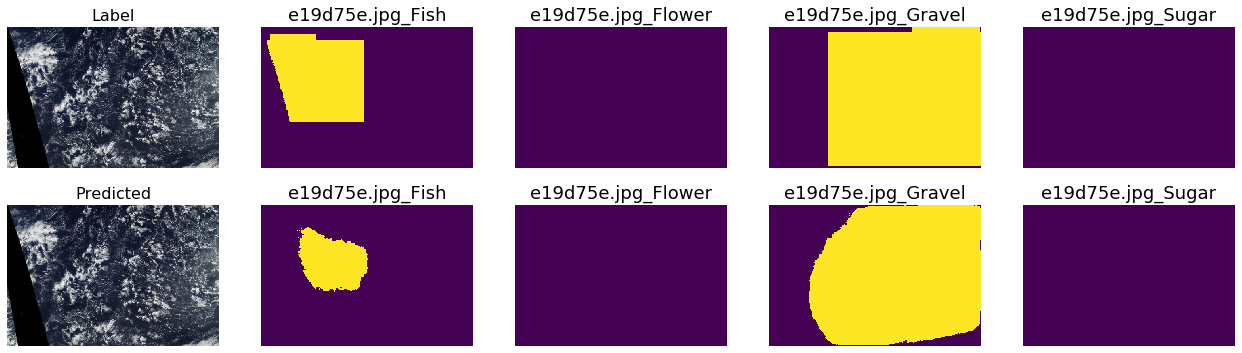

In [81]:
images_to_inspect = np.random.choice(X_val['image'].unique(), 4, replace=False)
inspect_set = train[train['image'].isin(images_to_inspect)].copy()
inspect_set_class = X_val[X_val['image'].isin(images_to_inspect)].copy()
inspect_set_temp = []

inspect_generator = DataGenerator(
                    directory=train_images_path,
                    dataframe=inspect_set,
                    target_df=train,
                    batch_size=1, 
                    target_size=(SEG_HEIGHT, SEG_WIDTH),
                    n_channels=CHANNELS,
                    n_classes=N_CLASSES,
                    preprocessing=preprocessing,
                    seed=seed,
                    mode='fit',
                    shuffle=False)

preds = segmentation_model1.predict_generator(inspect_generator) * model1_weights
preds += segmentation_model2.predict_generator(inspect_generator) * model2_weights
preds += segmentation_model3.predict_generator(inspect_generator) * model3_weights
preds += segmentation_model4.predict_generator(inspect_generator) * model4_weights

for index, b in enumerate(range(len(preds))):
    filename = inspect_set['image'].iloc[b]
    image_df = inspect_set[inspect_set['image'] == filename].copy()
    pred_masks = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks[..., class_index]
        pred_mask = post_process(pred_mask, threshold=.5, min_size=0)
        pred_masks[...,class_index] = pred_mask

    pred_rles = build_rles(pred_masks, reshape=(350, 525))
    image_df['EncodedPixels_pred'] = pred_rles
    
    ### Post procecssing
    pred_masks_post = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks_post[..., class_index]
        pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
        pred_masks_post[...,class_index] = pred_mask

    pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
    image_df['EncodedPixels_pred_post'] = pred_rles_post
    
    inspect_set_temp.append(image_df)

inspect_set = pd.concat(inspect_set_temp)
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred')

### With post-process

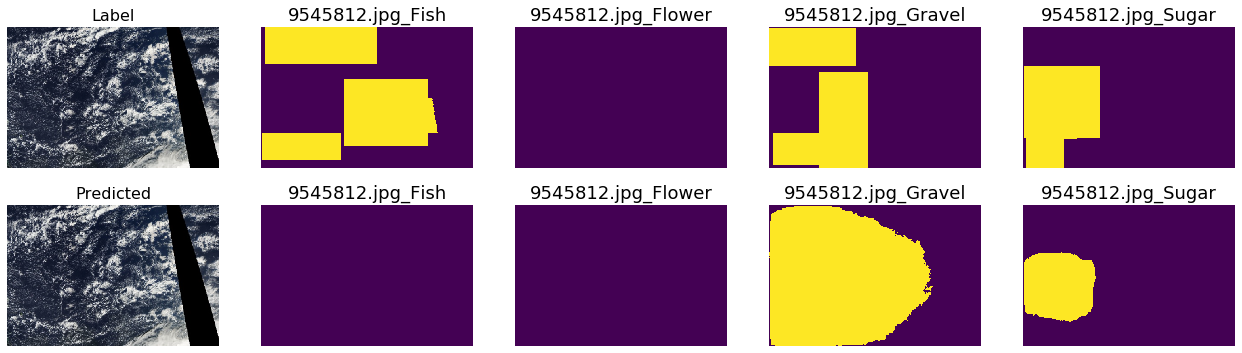

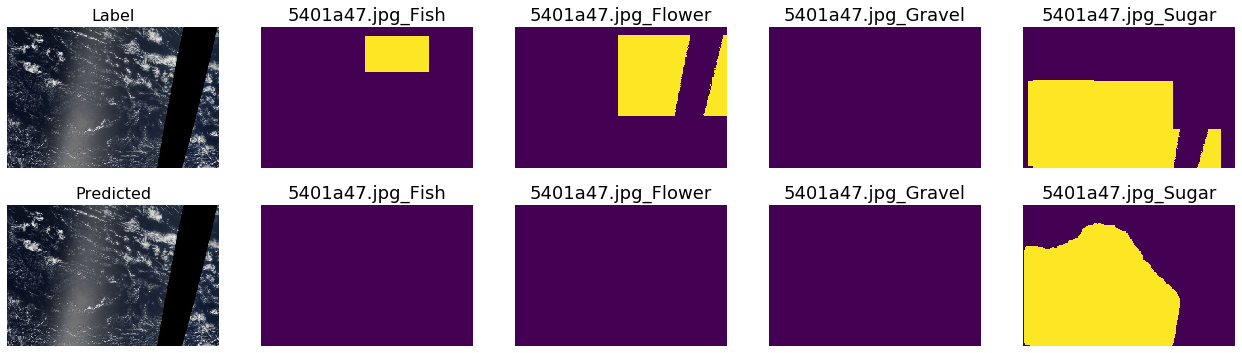

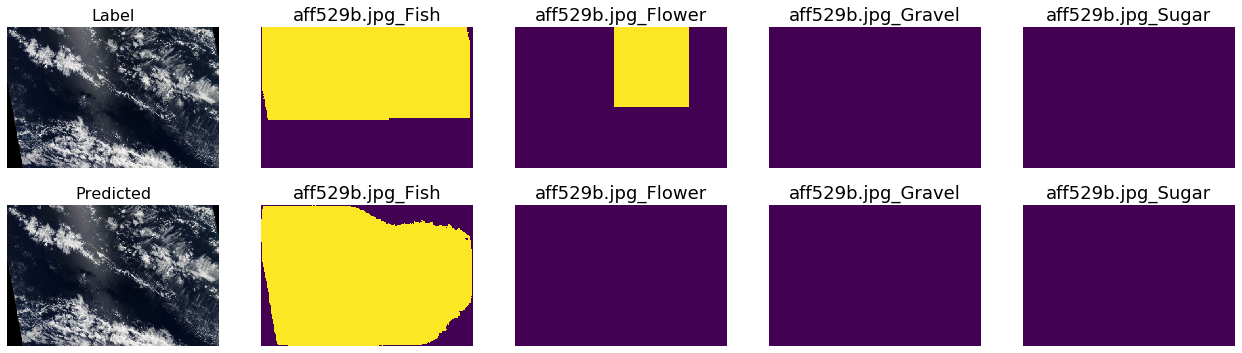

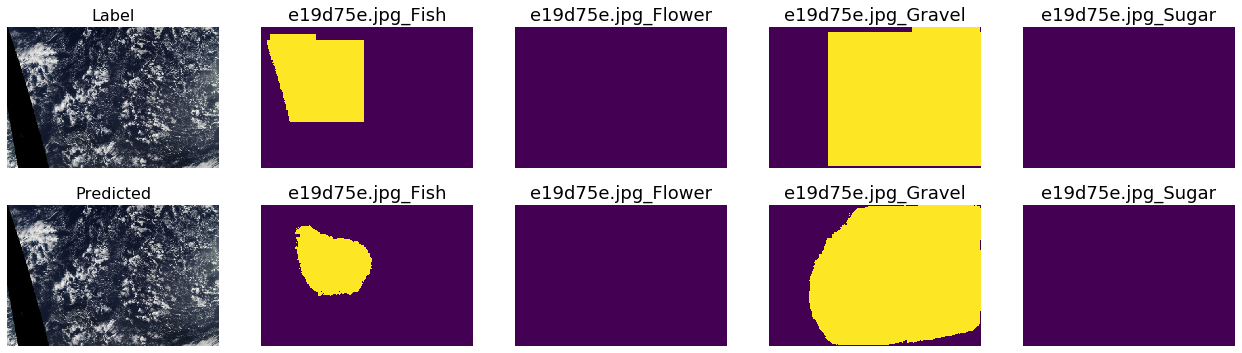

In [82]:
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred_post')

### Classification data generator

In [83]:
test_datagen=ImageDataGenerator(rescale=1./255.,
                                vertical_flip=True,
                                horizontal_flip=True,
                                zoom_range=[1, 1.2],
                                fill_mode='constant',
                                cval=0.)

classification_test_generator=test_datagen.flow_from_dataframe(
                                            dataframe=test,
                                            directory=test_images_path,
                                            x_col="image",
                                            target_size=(CLASS_HEIGHT, CLASS_WIDTH),
                                            class_mode=None,
                                            batch_size=1,
                                            shuffle=False,
                                            seed=seed)

Found 3698 validated image filenames.


# Using TTA Wrapper

In [0]:
segmentation_model_tta1 = tta_segmentation(segmentation_model1, h_flip=True, v_flip=True, rotation=(180), merge='mean', input_shape=(None, None, 3))
segmentation_model_tta2 = tta_segmentation(segmentation_model2, h_flip=True, v_flip=True, rotation=(180), merge='mean', input_shape=(None, None, 3))
segmentation_model_tta3 = tta_segmentation(segmentation_model3, h_flip=True, v_flip=True, rotation=(180), merge='mean', input_shape=(None, None, 3))
segmentation_model_tta4 = tta_segmentation(segmentation_model4, h_flip=True, v_flip=True, rotation=(180), merge='mean', input_shape=(None, None, 3))

# Apply segmentation model to test set (TTA)

In [0]:
#@title
test_df = []

for i in range(0, test.shape[0], 300):
    batch_idx = list(range(i, min(test.shape[0], i + 300)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(SEG_HEIGHT, SEG_WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = segmentation_model_tta1.predict_generator(test_generator) * model1_weights
    preds += segmentation_model_tta2.predict_generator(test_generator) * model2_weights
    preds += segmentation_model_tta3.predict_generator(test_generator) * model3_weights
    preds += segmentation_model_tta4.predict_generator(test_generator) * model4_weights

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks[..., class_index]
            pred_mask = post_process(pred_mask, threshold=.5, min_size=15000)
            pred_masks[...,class_index] = pred_mask

        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels_tta'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post_tta'] = pred_rles_post
        
        test_df.append(image_df)

X_test_tta = pd.concat(test_df)

# Apply classifcation model to test set

In [0]:
test_class_preds = apply_tta(classification_model, classification_test_generator, steps=TTA_STEPS)

for index in range(len(label_columns)):
  test_class_preds[:,index] = (test_class_preds[:,index] > best_tresholds_class[index]).astype(int)

X_test_tta['empty_mask'] = test_class_preds.reshape(test_class_preds.shape[0]*N_CLASSES)
X_test_tta['EncodedPixels_post_tta_class'] = X_test_tta.apply(lambda row: row['EncodedPixels_post_tta'] if row['empty_mask'] == 0 else '', axis=1)

### Number of masks removed

In [88]:
print('Using TTA wrapper')
print('Masks removed in "%s": %s' % ('EncodedPixels_post_tta_class', len(X_test_tta[(X_test_tta['EncodedPixels_post_tta'] != '') & (X_test_tta['empty_mask'] == 1)])))

Using TTA wrapper
Masks removed in "EncodedPixels_post_tta_class": 253


## Inspecting some of the test set predictions

### Without post-process and TTA

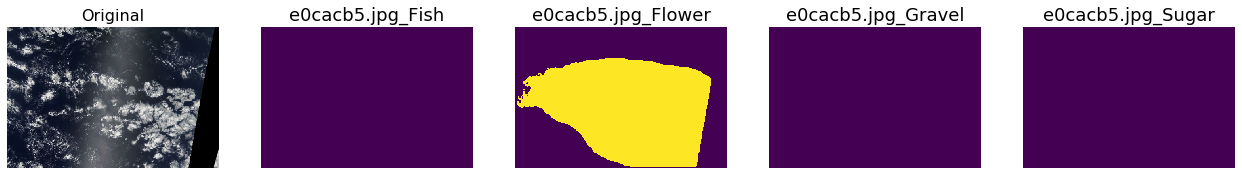

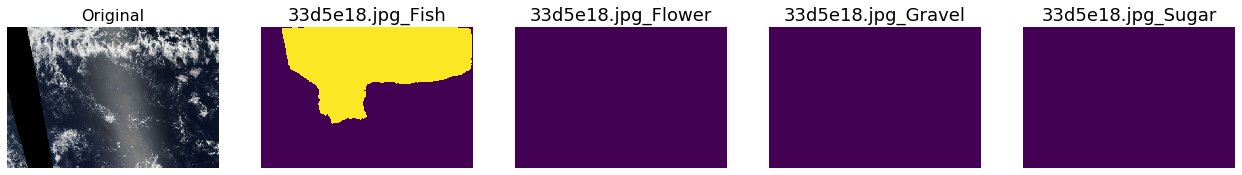

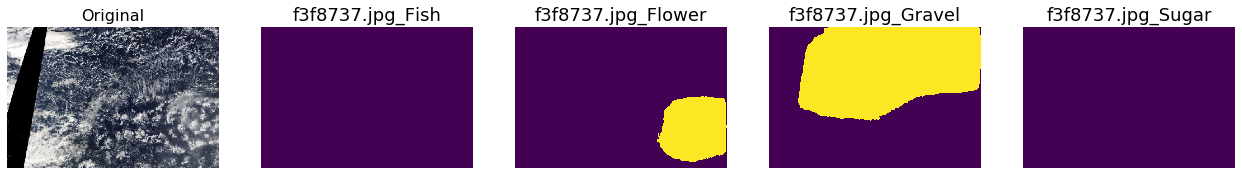

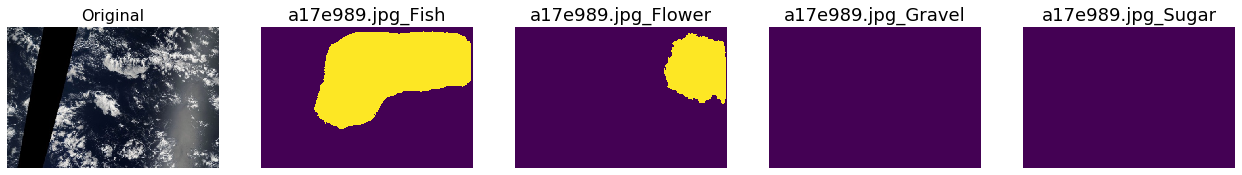

In [89]:
images_to_inspect_test =  np.random.choice(X_test_tta['image'].unique(), 4, replace=False)
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_tta')

### With post-process and TTA

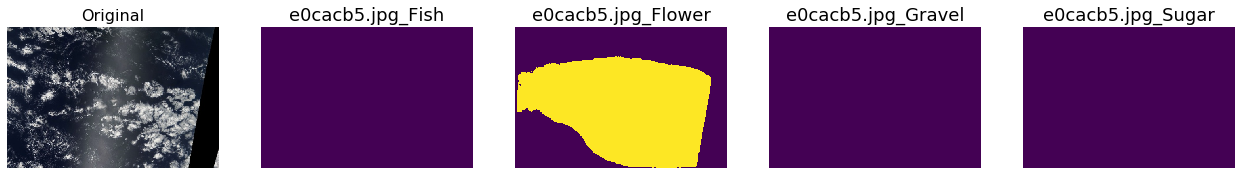

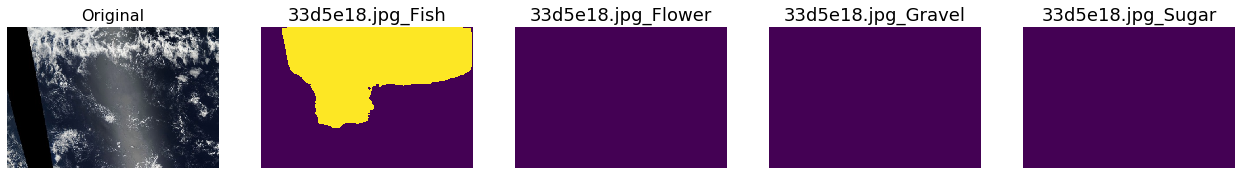

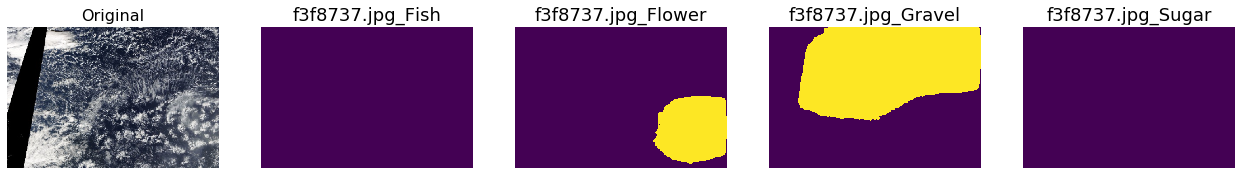

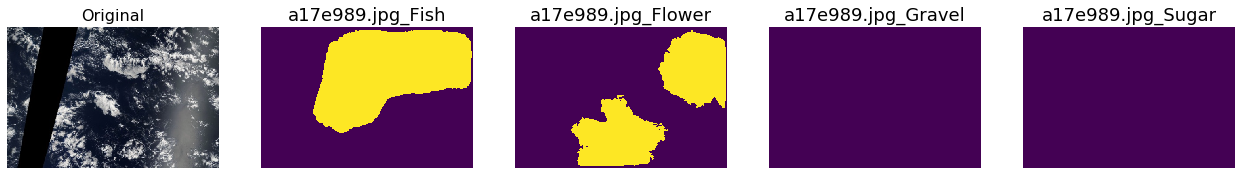

In [90]:
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_tta')

### Submission with post processing and TTA

In [91]:
submission_df = X_test_tta[['Image_Label' ,'EncodedPixels_post_tta']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post_tta_path, index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,15 217 242 7 256 65 365 217 592 7 606 65 710 2...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing, mask classification and TTA (beta 0.5)

In [92]:
submission_df = X_test_tta[['Image_Label' ,'EncodedPixels_post_tta_class']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post_tta_class_path, index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,15 217 242 7 256 65 365 217 592 7 606 65 710 2...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,
